In [1]:
import os
import time
import pandas as pd
import torch
import optuna
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Admin\anaconda3\envs\chandra\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset

In [2]:
df = pd.read_csv('final_dataset.csv')

In [3]:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [5]:
train_encodings = tokenizer.batch_encode_plus(X_train.tolist(),
                                              add_special_tokens=True,
                                              max_length=128,  # Reduced max_length for efficiency
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_tensors='pt')

In [6]:
test_encodings = tokenizer.batch_encode_plus(X_test.tolist(),
                                             add_special_tokens=True,
                                             max_length=128,  # Reduced max_length for efficiency
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_tensors='pt')

In [7]:
label_mapping = {'fake': 0, 'genuine': 1}

In [8]:
y_train_num = [label_mapping[label] for label in y_train]
y_test_num = [label_mapping[label] for label in y_test]

In [9]:
class YelpDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: v.clone().detach() for k, v in encodings.items()}
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = YelpDataset(train_encodings, y_train_num)
test_dataset = YelpDataset(test_encodings, y_test_num)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch_size for smaller data
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
def save_checkpoint(model, optimizer, epoch, batch_idx, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

In [13]:
def load_checkpoint(model, optimizer, path='checkpoint.pth'):
    if os.path.isfile(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch_idx = checkpoint['batch_idx']
        return epoch, batch_idx
    else:
        return None, None

In [14]:
train_losses = []
train_accuracies = []

In [15]:
def train(model, device, loader, optimizer, start_epoch, start_batch_idx, criterion, patience=3):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()
    checkpoint_interval = 30 * 60  # 30 minutes in seconds
    best_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(start_epoch, 8):  # Adjust the range as needed
        epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_predictions = 0
        for batch_idx, batch in enumerate(loader):
            if epoch == start_epoch and batch_idx < start_batch_idx:
                continue  # Skip batches already processed in the previous run
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            epoch_loss += loss.item()

            # Calculate training accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            epoch_correct_predictions += (predictions == labels).sum().item()
            epoch_total_predictions += labels.size(0)

            # Check if 30 minutes have passed
            elapsed_time = time.time() - start_time
            if elapsed_time >= checkpoint_interval:
                print(f'Saving checkpoint at epoch {epoch}, batch {batch_idx}')
                save_checkpoint(model, optimizer, epoch, batch_idx)
                start_time = time.time()  # Reset the start time
        avg_epoch_loss = epoch_loss / len(loader)
        epoch_accuracy = epoch_correct_predictions / epoch_total_predictions
        print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Early stopping
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [16]:
def evaluate(model, device, loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [17]:
def plot_roc_curve(true_labels, predictions, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2, hidden_dropout_prob=dropout_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    avg_loss, accuracy = train(model, device, train_loader, optimizer, 0, 0, criterion)
    predictions, true_labels = evaluate(model, device, test_loader)
    test_accuracy = accuracy_score(y_test_num, predictions)
    
    return test_accuracy

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-07-11 11:30:10,763] A new study created in memory with name: no-name-683f882c-654c-42c3-8bf4-6d134fb1174f
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a 

Epoch 1, Loss: 0.5223, Accuracy: 0.7862
Epoch 2, Loss: 0.4789, Accuracy: 0.7866
Epoch 3, Loss: 0.4269, Accuracy: 0.8006
Saving checkpoint at epoch 3, batch 2063
Epoch 4, Loss: 0.4063, Accuracy: 0.8148
Epoch 5, Loss: 0.3922, Accuracy: 0.8200
Epoch 6, Loss: 0.3798, Accuracy: 0.8290
Epoch 7, Loss: 0.3752, Accuracy: 0.8311
Saving checkpoint at epoch 7, batch 1413
Epoch 8, Loss: 0.3700, Accuracy: 0.8332


[I 2024-07-11 12:34:41,568] Trial 0 finished with value: 0.8380097268986157 and parameters: {'learning_rate': 5.319090761574096e-06, 'batch_size': 16, 'dropout_rate': 0.2606321952528055}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at alb

Epoch 1, Loss: 0.5264, Accuracy: 0.7862
Epoch 2, Loss: 0.5242, Accuracy: 0.7868
Epoch 3, Loss: 0.5221, Accuracy: 0.7867
Saving checkpoint at epoch 3, batch 2883
Epoch 4, Loss: 0.5208, Accuracy: 0.7868
Epoch 5, Loss: 0.5207, Accuracy: 0.7868
Epoch 6, Loss: 0.5204, Accuracy: 0.7868
Epoch 7, Loss: 0.4476, Accuracy: 0.7926
Saving checkpoint at epoch 7, batch 438
Epoch 8, Loss: 0.4008, Accuracy: 0.8151


[I 2024-07-11 13:43:12,293] Trial 1 finished with value: 0.8197717919940142 and parameters: {'learning_rate': 2.8018564400281653e-05, 'batch_size': 8, 'dropout_rate': 0.3205120824261672}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at alb

Epoch 1, Loss: 0.5268, Accuracy: 0.7866
Epoch 2, Loss: 0.5255, Accuracy: 0.7868
Epoch 3, Loss: 0.5253, Accuracy: 0.7868
Saving checkpoint at epoch 3, batch 2868
Epoch 4, Loss: 0.5238, Accuracy: 0.7868
Epoch 5, Loss: 0.5237, Accuracy: 0.7868
Epoch 6, Loss: 0.5233, Accuracy: 0.7868
Epoch 7, Loss: 0.5229, Accuracy: 0.7868
Saving checkpoint at epoch 7, batch 410
Epoch 8, Loss: 0.5225, Accuracy: 0.7868


[I 2024-07-11 14:51:45,710] Trial 2 finished with value: 0.7759072203516648 and parameters: {'learning_rate': 7.390117119859398e-05, 'batch_size': 8, 'dropout_rate': 0.3600132674904043}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albe

Epoch 1, Loss: 0.5283, Accuracy: 0.7826
Epoch 2, Loss: 0.5222, Accuracy: 0.7867
Epoch 3, Loss: 0.5198, Accuracy: 0.7867
Saving checkpoint at epoch 3, batch 1992
Epoch 4, Loss: 0.5119, Accuracy: 0.7868
Epoch 5, Loss: 0.4810, Accuracy: 0.7870
Epoch 6, Loss: 0.4498, Accuracy: 0.7920
Epoch 7, Loss: 0.4308, Accuracy: 0.7989
Saving checkpoint at epoch 7, batch 1304
Epoch 8, Loss: 0.4188, Accuracy: 0.8066


[I 2024-07-11 15:56:35,735] Trial 3 finished with value: 0.8293116348671904 and parameters: {'learning_rate': 2.9859664423262812e-06, 'batch_size': 16, 'dropout_rate': 0.3281751128683444}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at al

Epoch 1, Loss: 0.4970, Accuracy: 0.7861
Epoch 2, Loss: 0.4110, Accuracy: 0.8079
Epoch 3, Loss: 0.3756, Accuracy: 0.8300
Saving checkpoint at epoch 3, batch 1243
Epoch 4, Loss: 0.3406, Accuracy: 0.8500
Epoch 5, Loss: 0.3118, Accuracy: 0.8642
Epoch 6, Loss: 0.2788, Accuracy: 0.8819
Epoch 7, Loss: 0.2535, Accuracy: 0.8956
Saving checkpoint at epoch 7, batch 1157
Epoch 8, Loss: 0.2328, Accuracy: 0.9070


[I 2024-07-11 16:58:19,284] Trial 4 finished with value: 0.805181444070333 and parameters: {'learning_rate': 5.834729314560045e-05, 'batch_size': 32, 'dropout_rate': 0.1663722070124038}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albe

Epoch 1, Loss: 0.5251, Accuracy: 0.7851
Epoch 2, Loss: 0.5199, Accuracy: 0.7868
Epoch 3, Loss: 0.5195, Accuracy: 0.7868
Saving checkpoint at epoch 3, batch 2021
Epoch 4, Loss: 0.5208, Accuracy: 0.7868
Epoch 5, Loss: 0.5104, Accuracy: 0.7870
Epoch 6, Loss: 0.4719, Accuracy: 0.7867
Epoch 7, Loss: 0.4522, Accuracy: 0.7911
Saving checkpoint at epoch 7, batch 1358
Epoch 8, Loss: 0.4585, Accuracy: 0.7876


[I 2024-07-11 18:02:58,769] Trial 5 finished with value: 0.7890011223344556 and parameters: {'learning_rate': 2.9313319481402937e-06, 'batch_size': 16, 'dropout_rate': 0.3045252477454002}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at al

Epoch 1, Loss: 0.5261, Accuracy: 0.7867
Epoch 2, Loss: 0.5247, Accuracy: 0.7868
Epoch 3, Loss: 0.5246, Accuracy: 0.7868
Saving checkpoint at epoch 3, batch 2860
Epoch 4, Loss: 0.5244, Accuracy: 0.7868
Epoch 5, Loss: 0.5243, Accuracy: 0.7868
Epoch 6, Loss: 0.5238, Accuracy: 0.7868
Epoch 7, Loss: 0.5236, Accuracy: 0.7868
Saving checkpoint at epoch 7, batch 386
Epoch 8, Loss: 0.5242, Accuracy: 0.7868


[I 2024-07-11 19:11:34,711] Trial 6 finished with value: 0.7759072203516648 and parameters: {'learning_rate': 2.6675722653796126e-05, 'batch_size': 8, 'dropout_rate': 0.15979815776405998}. Best is trial 0 with value: 0.8380097268986157.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at al

Epoch 1, Loss: 0.4624, Accuracy: 0.7925
Epoch 2, Loss: 0.3904, Accuracy: 0.8214
Epoch 3, Loss: 0.3747, Accuracy: 0.8280
Saving checkpoint at epoch 3, batch 1997
Epoch 4, Loss: 0.3663, Accuracy: 0.8357
Epoch 5, Loss: 0.3572, Accuracy: 0.8392
Epoch 6, Loss: 0.3529, Accuracy: 0.8417
Epoch 7, Loss: 0.3497, Accuracy: 0.8446
Saving checkpoint at epoch 7, batch 1324
Epoch 8, Loss: 0.3462, Accuracy: 0.8443


[I 2024-07-11 20:16:21,030] Trial 7 finished with value: 0.8457725402169847 and parameters: {'learning_rate': 1.4860545993979462e-06, 'batch_size': 16, 'dropout_rate': 0.14546046928779585}. Best is trial 7 with value: 0.8457725402169847.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at a

Epoch 1, Loss: 0.5266, Accuracy: 0.7865
Epoch 2, Loss: 0.5250, Accuracy: 0.7868
Epoch 3, Loss: 0.5228, Accuracy: 0.7868
Saving checkpoint at epoch 3, batch 1248
Epoch 4, Loss: 0.5211, Accuracy: 0.7868
Epoch 5, Loss: 0.5197, Accuracy: 0.7868
Epoch 6, Loss: 0.5201, Accuracy: 0.7868
Epoch 7, Loss: 0.5196, Accuracy: 0.7868
Saving checkpoint at epoch 7, batch 1172
Epoch 8, Loss: 0.5196, Accuracy: 0.7868


[I 2024-07-11 21:17:58,873] Trial 8 finished with value: 0.7759072203516648 and parameters: {'learning_rate': 4.677659196441353e-05, 'batch_size': 32, 'dropout_rate': 0.3277229368890967}. Best is trial 7 with value: 0.8457725402169847.
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2675487477.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at alb

Epoch 1, Loss: 0.5228, Accuracy: 0.7867
Epoch 2, Loss: 0.5209, Accuracy: 0.7868
Epoch 3, Loss: 0.5199, Accuracy: 0.7868
Saving checkpoint at epoch 3, batch 2893
Epoch 4, Loss: 0.5198, Accuracy: 0.7868
Epoch 5, Loss: 0.5196, Accuracy: 0.7868
Epoch 6, Loss: 0.5195, Accuracy: 0.7868
Epoch 7, Loss: 0.5194, Accuracy: 0.7868
Saving checkpoint at epoch 7, batch 451
Epoch 8, Loss: 0.5193, Accuracy: 0.7868


[I 2024-07-11 22:26:27,768] Trial 9 finished with value: 0.7759072203516648 and parameters: {'learning_rate': 7.537945180920107e-05, 'batch_size': 8, 'dropout_rate': 0.3003157974499606}. Best is trial 7 with value: 0.8457725402169847.


In [20]:
best_trial = study.best_trial
print(f'Best trial: Value: {best_trial.value}, Params: {best_trial.params}')

Best trial: Value: 0.8457725402169847, Params: {'learning_rate': 1.4860545993979462e-06, 'batch_size': 16, 'dropout_rate': 0.14546046928779585}


Use the best hyperparameters to train the final model

In [21]:
best_params = best_trial.params
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']

In [22]:
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2, hidden_dropout_prob=best_dropout_rate)
model.to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.14546046928779585, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768,

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
avg_loss, accuracy = train(model, device, train_loader, optimizer, 0, 0, criterion)

Epoch 1, Loss: 0.5038, Accuracy: 0.7850
Epoch 2, Loss: 0.4292, Accuracy: 0.8024
Epoch 3, Loss: 0.4091, Accuracy: 0.8136
Saving checkpoint at epoch 3, batch 2020
Epoch 4, Loss: 0.4082, Accuracy: 0.8142
Epoch 5, Loss: 0.3860, Accuracy: 0.8247
Epoch 6, Loss: 0.3763, Accuracy: 0.8308
Epoch 7, Loss: 0.3708, Accuracy: 0.8330
Saving checkpoint at epoch 7, batch 1359
Epoch 8, Loss: 0.3659, Accuracy: 0.8363


In [27]:
predictions, true_labels = evaluate(model, device, test_loader)
test_accuracy = accuracy_score(y_test_num, predictions)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Test Accuracy: 0.8450


In [28]:
# user_input = input("Enter text for prediction (or type 'exit' to quit): ")
# prediction = predict(model, tokenizer, user_input, device)
# print(f'Predicted class: {prediction}')

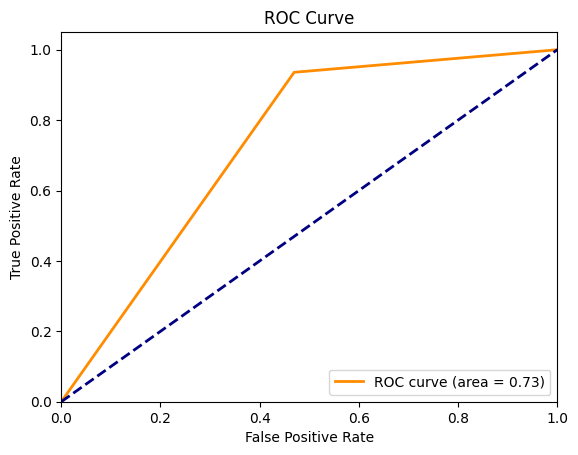

In [29]:
plot_roc_curve(y_test_num, predictions)

In [30]:
epochs = list(range(1, len(train_losses) + 1))

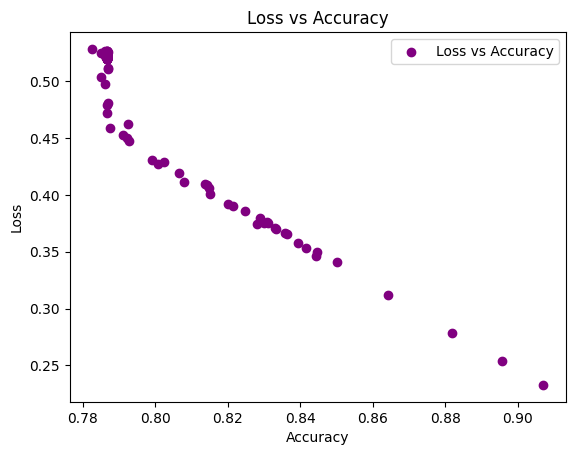

In [31]:
plt.figure()
plt.scatter(train_accuracies, train_losses, label='Loss vs Accuracy', color='purple')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Loss vs Accuracy')
plt.legend()
plt.show()